# Задача:
Есть последовательность ДНК. Как известно, она состоит из букв A, C, T, G. В биоинформатике есть такая задача - предсказывать недостающие данные (пропуски) в последовательности генов. Например, есть пропуск в последовательности. Знаем, что есть 5-30 известных символов слева, 5-30 известных символов - справа от этого пропуска. Вам предоставляется файл расширения fasta.

In [198]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
from Bio import SeqIO
from Bio.Seq import Seq
import tensorflow as tf

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows',50) 
pd.set_option('display.max_columns',50) 
pd.set_option('display.width', None)

tf.enable_eager_execution()

In [190]:
from tensorflow.core.protobuf import rewriter_config_pb2
from tensorflow.keras.backend import set_session
tf.keras.backend.clear_session()  # For easy reset of notebook state.

config_proto = tf.ConfigProto()
off = rewriter_config_pb2.RewriterConfig.OFF
config_proto.graph_options.rewrite_options.arithmetic_optimization = off
session = tf.Session(config=config_proto)
set_session(session)

# Извлекаем данные:

В Python cуществует специализированная библиотека **BioPython**, предназначенная специально для чтения файлов с расширением fasta и агрегацией необходимой информации. 
**FASTA** — текстовый формат для нуклеотидных или полипептидных последовательностей, в котором нуклеотиды или аминокислоты обозначаются при помощи однобуквенных кодов.

In [256]:
with open('mart_export.fasta') as fasta_file:  
    seq = []                                            # список последовательностей ДНК
    lengths = []                                        # список длин последовательностей                               
    for seq_record in SeqIO.parse(fasta_file, 'fasta'): # цикл перебора последовательностей
        seq.append(seq_record.seq)
        lengths.append(len(seq_record.seq))

Создадим датафрейм полученных значений:

In [257]:
dt = pd.DataFrame({'DNA_seq':seq ,'Lenght':lengths})    

In [258]:
dt.head(5)

,DNA_seq,Lenght
0,"(A, T, G, G, A, G, A, T, C, C, C, T, G, T, G, ...",483
1,"(A, T, G, C, A, G, A, G, G, T, C, G, C, C, T, ...",4443
2,"(A, T, G, C, T, T, C, T, G, G, G, C, G, A, G, ...",975
3,"(A, T, G, C, G, G, C, C, C, C, A, G, G, A, G, ...",1404
4,"(A, T, G, C, T, C, T, T, T, G, A, G, G, G, C, ...",1539


# Анализируем датасет:

In [259]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249158 entries, 0 to 249157
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   DNA_seq  249158 non-null  object
 1   Lenght   249158 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.8+ MB


Итак датасет имеет порядка 250 тыс. строк. Все строки заполнены значениями.

In [260]:
dt['DNA_seq'].describe()

count                                                249158
unique                                                89658
top       (S, e, q, u, e, n, c, e, u, n, a, v, a, i, l, ...
freq                                                 138370
Name: DNA_seq, dtype: object

In [261]:
Not_avail = round((dt['DNA_seq'].describe()[3]/dt['DNA_seq'].describe()[0])*100,2)
lenght = len(dt['DNA_seq'].describe()[2])
print(f'Процент утерянных последовательностей ДНК: {Not_avail} %')
print(f'Длина утерянной последовательности ДНК: {lenght}')

Процент утерянных последовательностей ДНК: 55.54 %
Длина утерянной последовательности ДНК: 19


Анализ столбца 'DNA_seq' показал, что в большинстве случаев строки заполнены значением "Последовательность отсутствует". Процент отсутствующих последовательностей 55%.

In [262]:
dt['Lenght'].describe()

count    249158.000000
mean        517.774284
std        1183.656562
min           3.000000
25%          19.000000
50%          19.000000
75%         592.000000
max      107976.000000
Name: Lenght, dtype: float64

Вполне ожидаемо что медианное значение соответствует длине утерянных последовательностей ДНК, на этой основе легко будет отфильтровать лишние значения.

In [263]:
dt = dt[dt.Lenght != 19] # Отсекаем все что имеет длину 19 символов

In [264]:
dt['Lenght'].describe()

count    110774.000000
mean       1140.866169
std        1565.973858
min           3.000000
25%         364.000000
50%         708.000000
75%        1428.000000
max      107976.000000
Name: Lenght, dtype: float64

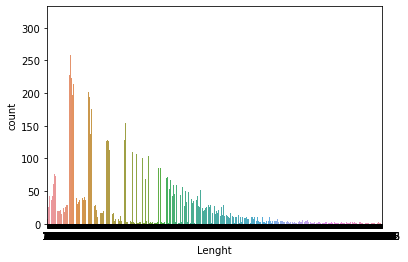

In [218]:
sns.countplot(x=dt['Lenght'], data=dt)

Самый простой способ отфильтровать выбросы — воспользоваться формулой интерквартильного расстояния (межквартильного размаха). Выбросом считаются такие значения, которые лежат вне рамок

percentile(25) -1.5IQR : percentile(75)+1.5IQR

IQR = percentile(75) - percentile(25).

In [265]:
percintile_25 = 364
percintile_75 = 1428
IQR = percintile_75 - percintile_25

Max = percintile_75 + 1.5*IQR

print(f'Границы выбросов - {0} : {Max}')

Границы выбросов - 0 : 3024.0


In [266]:
dt = dt[dt.Lenght < 3000]

In [267]:
dt.head(5)

,DNA_seq,Lenght
0,"(A, T, G, G, A, G, A, T, C, C, C, T, G, T, G, ...",483
2,"(A, T, G, C, T, T, C, T, G, G, G, C, G, A, G, ...",975
3,"(A, T, G, C, G, G, C, C, C, C, A, G, G, A, G, ...",1404
4,"(A, T, G, C, T, C, T, T, T, G, A, G, G, G, C, ...",1539
5,"(A, T, G, G, C, G, G, C, G, G, C, G, G, C, T, ...",1530


In [268]:
dt = dt.reset_index()
dt.drop(['index'], axis=1, inplace=True)

In [269]:
dt.drop(['Lenght'], axis=1, inplace=True)

In [270]:
dt.head(5)

,DNA_seq
0,"(A, T, G, G, A, G, A, T, C, C, C, T, G, T, G, ..."
1,"(A, T, G, C, T, T, C, T, G, G, G, C, G, A, G, ..."
2,"(A, T, G, C, G, G, C, C, C, C, A, G, G, A, G, ..."
3,"(A, T, G, C, T, C, T, T, T, G, A, G, G, G, C, ..."
4,"(A, T, G, G, C, G, G, C, G, G, C, G, G, C, T, ..."


Проверим наличие "лишних" символов в наших последовательностей:

In [271]:
O = []

for row in dt['DNA_seq']:
    Other = 0
    for i in row:
        if i == 'T' or i == 'C' or i == 'G' or i == 'A':
            pass
        else:
            Other +=1
    O.append(Other)

In [272]:
dt['O_sum'] = O

In [273]:
dt['O_sum'].describe()

count    103364.000000
mean          0.121454
std           0.430915
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           2.000000
Name: O_sum, dtype: float64

В датасете присутствуют такие последовательности. Значит выбросим их.

In [274]:
dt = dt[dt.O_sum == 0]

In [275]:
dt

,DNA_seq,O_sum
0,"(A, T, G, G, A, G, A, T, C, C, C, T, G, T, G, ...",0
1,"(A, T, G, C, T, T, C, T, G, G, G, C, G, A, G, ...",0
2,"(A, T, G, C, G, G, C, C, C, C, A, G, G, A, G, ...",0
3,"(A, T, G, C, T, C, T, T, T, G, A, G, G, G, C, ...",0
4,"(A, T, G, G, C, G, G, C, G, G, C, G, G, C, T, ...",0
...,...,...
103358,"(A, T, G, T, C, C, A, T, G, T, C, A, C, C, C, ...",0
103359,"(A, T, G, G, C, C, A, A, T, T, C, G, G, G, C, ...",0
103360,"(A, T, G, C, T, G, G, A, A, T, T, A, C, A, G, ...",0
103362,"(A, T, G, G, C, C, A, A, G, G, T, G, T, C, G, ...",0


Столбец O_sum нам более не нужен, удалим его:

In [276]:
dt.drop(['O_sum'], axis=1, inplace=True)

In [277]:
dt

,DNA_seq
0,"(A, T, G, G, A, G, A, T, C, C, C, T, G, T, G, ..."
1,"(A, T, G, C, T, T, C, T, G, G, G, C, G, A, G, ..."
2,"(A, T, G, C, G, G, C, C, C, C, A, G, G, A, G, ..."
3,"(A, T, G, C, T, C, T, T, T, G, A, G, G, G, C, ..."
4,"(A, T, G, G, C, G, G, C, G, G, C, G, G, C, T, ..."
...,...
103358,"(A, T, G, T, C, C, A, T, G, T, C, A, C, C, C, ..."
103359,"(A, T, G, G, C, C, A, A, T, T, C, G, G, G, C, ..."
103360,"(A, T, G, C, T, G, G, A, A, T, T, A, C, A, G, ..."
103362,"(A, T, G, G, C, C, A, A, G, G, T, G, T, C, G, ..."


In [391]:
df = dt.iloc[:100]
df

,DNA_seq
0,"(A, T, G, G, A, G, A, T, C, C, C, T, G, T, G, ..."
1,"(A, T, G, C, T, T, C, T, G, G, G, C, G, A, G, ..."
2,"(A, T, G, C, G, G, C, C, C, C, A, G, G, A, G, ..."
3,"(A, T, G, C, T, C, T, T, T, G, A, G, G, G, C, ..."
4,"(A, T, G, G, C, G, G, C, G, G, C, G, G, C, T, ..."
...,...
95,"(A, T, G, C, C, G, A, A, G, T, C, G, T, G, C, ..."
96,"(A, T, G, G, G, G, G, A, T, A, C, T, G, G, C, ..."
97,"(A, T, G, G, G, T, T, G, C, G, A, C, G, G, G, ..."
98,"(A, T, G, A, G, G, A, A, A, A, G, T, C, C, A, ..."


In [394]:
X_ts = []
Y_exepct = []
for i in df['DNA_seq']:
    X_ts.append(i[:45])
    Y_exepct.append(i[45:46])

In [278]:
Fout = open ( "DNA.txt", "w" ) 

lister = []
for i in dt['DNA_seq']:
    lister.append(i)

for x in lister:     
    Fout.write (str(x)+"\n"+"\n") 

In [281]:
text = open('DNA.txt', 'rb').read().decode(encoding='cp1251')
print (f'Длина текстового документа: {len(text)}')

Длина текстового документа: 85147518


Составим список уникальных символов в нашем текстовом документе: 

In [327]:
vocabulary = sorted(set(text))
print (f'Количество уникальных значений словаря {len(vocabulary)}')

Количество уникальных значений словаря 6


#  Векторизация:

Машины не умеют напрямую обрабатывать символьные признаки. Поэтому прежде чем подавать данные на вход алгоритма машинного обучения преобразуем категориальные признаки в количественные.

In [328]:
# Присваиваем каждому символу уникальное отображение
numeric = {u:i for i, u in enumerate(vocabulary)}      
index = np.array(vocabulary)                        
  

text_as_int = np.array([numeric[i] for i in text])
text_as_int

array([2, 5, 4, ..., 0, 1, 0])

Теперь у нас есть целочисленное представление для каждого символа.

In [329]:
for char,_ in zip(numeric, range(len(vocabulary))):
    print(f'{repr(char)} : {numeric[char]}')

'\n' : 0
'\r' : 1
'A' : 2
'C' : 3
'G' : 4
'T' : 5


Проверим на небольшом куске текста работу нашего преобразователя символов:

In [330]:
print (f'{(repr(text[:13]))} : {(text_as_int[:13])}')

'ATGGAGATCCCTG' : [2 5 4 4 2 4 2 5 3 3 3 5 4]


# Создание обучающей выборки и выходных признаков:

Входными данными для модели будет последовательность символов, наша задача обучить модель прогнозировать выходные данные - следующий символ на каждом временном шаге.

RNN поддерживает  внутреннее состояние, которое зависит от ранее определенных элементов, учитывая все символы, вычисленные до настоящего момента.

Разделим текст на последовательности для обучающей выборки. Каждая входная последовательность будет содержать символы seq_length из текста.Для каждой входной последовательности соответствующий выходной признак будет содержат одинаковую длину текста со смещением на один символ вправо.

Для этого используем функцию tf.data.Dataset.from_tensor_slices, чтобы преобразовать текстовый вектор в поток символьных индексов.

In [331]:
# Из задания: знаем, что есть 5-30 известных символов слева:
# Максимальная длина последовательнсти, которое мы хотим для одного ввода в символах
seq_length = 30
examples_per_epoch = len(text)//(seq_length+1)

# Создаем учебные примеры / целевые признаки
symb_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in symb_dataset.take(15):
    print(index[i.numpy()])

A
T
G
G
A
G
A
T
C
C
C
T
G
T
G


Пакетный метод позволяет нам легко конвертировать отдельные символы в последовательности нужного нам размера.

In [332]:
sequences = symb_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(5):
    print(repr(''.join(index[item.numpy()])))

'ATGGAGATCCCTGTGCCTGTGCAGCCGTCTT'
'GGCTGCGCCGCGCCTCGGCCCCGTTGCCCGG'
'ACTTTCGGCGCCCGGACGCCTCTTTGACCAG'
'CGCTTCGGCGAGGGGCTGCTGGAGGCCGAGC'
'TGGCTGCGCTCTGCCCCACCACGCTCGCCCC'


Для каждой последовательности продублируем ее и сдвинем, чтобы сформировать входной и целевой текст.
Используем метод map для применения простой функции к каждому пакету:

In [333]:
def SplitTarget(leng):                #split_input_target
    input_text = leng[:-1]
    target_text = leng[1:]
    return input_text, target_text

dataset = sequences.map(SplitTarget)

Выведем пример 'входной' и 'целевой' символьной последовательности:

In [334]:
for input_example, target_example in  dataset.take(1):
    enter = repr(''.join(index[input_example.numpy()]))
    exit = repr(''.join(index[target_example.numpy()]))
    print(f'Входная посл - ть: {enter}')
    print(f'Выходная посл - ть: {exit}')

Входная посл - ть: 'ATGGAGATCCCTGTGCCTGTGCAGCCGTCT'
Выходная посл - ть: 'TGGAGATCCCTGTGCCTGTGCAGCCGTCTT'


In [335]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print("Шаг {:4d}".format(i))
    print("  Вход: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  Ожидаемый выход: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Шаг    0
  Вход: 2 ('A')
  Ожидаемый выход: 5 ('T')
Шаг    1
  Вход: 5 ('T')
  Ожидаемый выход: 4 ('G')
Шаг    2
  Вход: 4 ('G')
  Ожидаемый выход: 4 ('G')
Шаг    3
  Вход: 4 ('G')
  Ожидаемый выход: 2 ('A')
Шаг    4
  Вход: 2 ('A')
  Ожидаемый выход: 4 ('G')


# Создаем тренировочные послед-ти:

Мы использовали tf.data для разделения текста на управляемые последовательности. Но прежде чем вводить эти данные в модель, нам нужно перемешать данные и упаковать их в пакеты.

In [336]:
BATCH_SIZE = 100

In [337]:
BUFFER_SIZE = 10000

In [338]:
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
dataset

<DatasetV1Adapter shapes: ((100, 30), (100, 30)), types: (tf.int32, tf.int32)>

# Создаем модель:

In [339]:
# размер списка уникальных значений
vocab_size = len(vocabulary)
# Размер вложения
embedding_dim = 128
# Количество блоков RNN
rnn_units = 256

In [340]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.GRU(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [341]:
model = build_model(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

Для каждого символа модель ищет вложение, запускает один шаг GRU с вложением в качестве входных данных и применяет плотный слой для создания логитов, предсказывающих логарифмическую вероятность следующего символа:

# Пробный запуск модели:

Теперь запустим модель, чтобы убедиться, что она ведет себя так, как ожидалось.

In [343]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape)

(100, 30, 6)


В вышеприведенном примере длина последовательности ввода равна 100, но модель можно запустить на входах любой длины:

In [344]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (100, None, 128)          768       
_________________________________________________________________
gru (GRU)                    (100, None, 256)          295680    
_________________________________________________________________
dense (Dense)                (100, None, 6)            1542      
Total params: 297,990
Trainable params: 297,990
Non-trainable params: 0
_________________________________________________________________


In [345]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

In [346]:
sampled_indices

array([2, 5, 5, 2, 0, 4, 4, 2, 5, 2, 0, 0, 3, 1, 5, 2, 5, 2, 4, 3, 1, 3,
       0, 4, 1, 5, 0, 2, 2, 0], dtype=int64)

Расшифруем ее, чтобы увидеть текст, предсказанный этой неподготовленной моделью:

In [362]:
print("След. символ: \n", repr("".join(index[sampled_indices][0])))

След. символ: 
 'A'


# Обучение модели:

На этом этапе проблема может рассматриваться как стандартная проблема классификации. Учитывая предыдущее состояние RNN и ввод этого временного шага, предсказать класс следующего символа.

In [363]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss  = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (100, 30, 6)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       1.7925793


Настроем процедуру обучения с помощью метода tf.keras.Model.compile. Мы будем использовать tf.keras.optimizers.Adam с аргументами по умолчанию и функцией потерь.

In [364]:
model.compile(optimizer='adam', loss=loss)

Используйте tf.keras.callbacks.ModelCheckpoint, чтобы гарантировать сохранение контрольных точек во время обучения:

In [365]:
# Каталог, в котором будут сохранены контрольные точки
checkpoint_dir = './training_checkpoints'
# Имя файлов контрольных точек
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

### Задаем количество эпох:

In [369]:
EPOCHS=10

In [370]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/10
27466/27466 [==============================] - 3356s 122ms/step - loss: 1.3207
Epoch 2/10
27466/27466 [==============================] - 3338s 122ms/step - loss: 1.3195
Epoch 3/10
27466/27466 [==============================] - 3363s 122ms/step - loss: 1.3194
Epoch 4/10
27466/27466 [==============================] - 3352s 122ms/step - loss: 1.3197
Epoch 5/10
27466/27466 [==============================] - 3350s 122ms/step - loss: 1.3205
Epoch 6/10
27466/27466 [==============================] - 3337s 122ms/step - loss: 1.3218
Epoch 7/10
27466/27466 [==============================] - 3371s 123ms/step - loss: 1.3280
Epoch 8/10
27466/27466 [==============================] - 3362s 122ms/step - loss: 1.3300
Epoch 9/10
27466/27466 [==============================] - 3378s 123ms/step - loss: 1.3325
Epoch 10/10
27466/27466 [==============================] - 3418s 124ms/step - loss: 1.3346


Из-за способа передачи состояния RNN от временного шага к временному шагу модель принимает фиксированный размер пакета только после создания.
Чтобы запустить модель с другим размером batch_size, нам нужно перестроить модель и восстановить весовые коэффициенты с контрольной точки.

In [371]:
tf.train.latest_checkpoint(checkpoint_dir)

'./training_checkpoints\\ckpt_10'

In [372]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [373]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 128)            768       
_________________________________________________________________
gru_1 (GRU)                  (1, None, 256)            295680    
_________________________________________________________________
dense_1 (Dense)              (1, None, 6)              1542      
Total params: 297,990
Trainable params: 297,990
Non-trainable params: 0
_________________________________________________________________


Состояние RNN, возвращаемое моделью, повторно возвращается в модель, так что теперь оно имеет больше контекста(веса), чем только один символ. После прогнозирования следующего символа измененные состояния RNN снова возвращаются в модель, что позволяет ей узнавать больше информации из ранее предсказанных символов.

In [419]:
def generate_text(model, start_string):
    num_generate = 1

    # Векторизуем изучаемую строку
    input_eval = [char2idx[s] for s in start_string]
    # возвращает тензор с дополнительным измерением, вставленным по оси индекса
    input_eval = tf.expand_dims(input_eval, 0)

    # Строка для хранения наших результатов
    text_generated = []

    temperature = 0.1

    # Batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        # удалить batch
        predictions = tf.squeeze(predictions, 0)

        # используем категориальное распределение для прогнозирования символа, возвращаемого моделью
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        # Мы передаем предсказанный символ как следующий вход в модель вместе с предыдущим скрытым состоянием
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])
        
        return (text_generated)

# Проверка:

In [420]:
result = []
for i in X_ts:
    result.append(generate_text(model, i))

In [421]:
Res = []
for i in result:
    for j in (i):
        Res.append(j)

In [422]:
counter = 0
for i, j in zip(Res,Y_exepct):
    if i == j:
        counter +=1
    else:
        pass

In [426]:
Per_of_guess = round((counter/len(X_ts))*100,2)
print(f'Процент правильно спрогнозируемых символов {Per_of_guess} %')

Процент правильно спрогнозируемых символов 40.0 %


# Вывод:

В данной работе была проведена попытка использования RNN сетей для прогнозирования выпавших символов цепочки ДНК. Выбор был обусловлен тем, что рекуррентные нейронные сети (RNN) — это класс нейронных сетей, которые хороши для моделирования последовательных данных, таких как временные ряды или естественный язык. Для первого приближения модель выдает 40% правильных результатов, это говорит о том что она требует более тонкой настройки и доработки, которая будет учтена в следующей версии.